### Setup

In [201]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [202]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Data

In [203]:
data = tf.keras.utils.image_dataset_from_directory('images')
data_iterator = data.as_numpy_iterator()

Found 1225 files belonging to 3 classes.


In [204]:
batch = data_iterator.next()
batch[0].shape  # 32 images per batch, 256x256 pixels, 3 channels (RGB)

(32, 256, 256, 3)

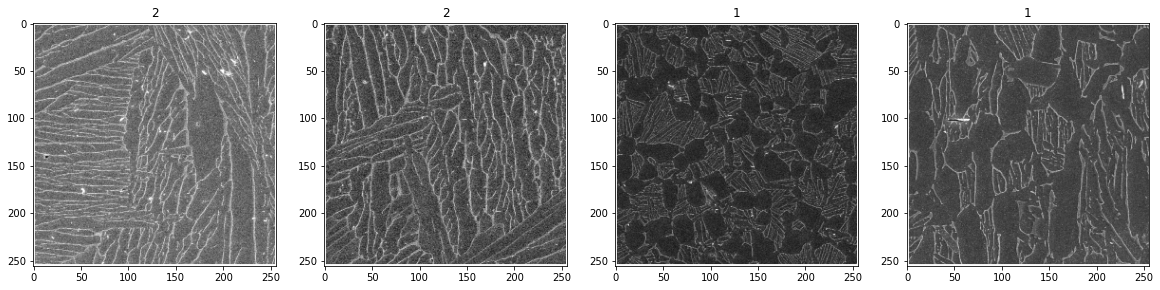

In [205]:
# Show images
# 0: acicular, 1: duplex, 2: lamellar
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocess Data

In [206]:
# Normalize images
scaled_data = data.map(lambda x, y: (x/255, y))  

In [207]:
# Split data
# len(scaled_data) = number of batches
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1

train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

train_size, val_size, test_size

(27, 8, 4)

### Build Model

In [208]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [209]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),  # 16 3x3 filters, 1 stride 
    MaxPooling2D(),
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')  # Multiclass classification
])

In [210]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [211]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

In [212]:
# Save model, checkpoints
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [213]:
history = model.fit(
    train,
    epochs=10,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
27/27 [==============================] - 34s 1s/step - loss: 0.9215 - accuracy: 0.5856 - val_loss: 0.6415 - val_accuracy: 0.7461
Epoch 2/10
27/27 [==============================] - 39s 1s/step - loss: 0.6679 - accuracy: 0.7060 - val_loss: 0.4488 - val_accuracy: 0.8086
Epoch 3/10
27/27 [==============================] - 43s 2s/step - loss: 0.4458 - accuracy: 0.8021 - val_loss: 0.2814 - val_accuracy: 0.8398
Epoch 4/10
27/27 [==============================] - 51s 2s/step - loss: 0.2541 - accuracy: 0.9282 - val_loss: 0.2229 - val_accuracy: 0.9492
Epoch 5/10
27/27 [==============================] - 43s 2s/step - loss: 0.2196 - accuracy: 0.9363 - val_loss: 0.1736 - val_accuracy: 0.9414
Epoch 6/10
27/27 [==============================] - 46s 2s/step - loss: 0.2126 - accuracy: 0.9352 - val_loss: 0.1920 - val_accuracy: 0.9492
Epoch 7/10
27/27 [==============================] - 38s 1s/step - loss: 0.1594 - accuracy: 0.9560 - val_loss: 0.1573 - val_accuracy: 0.9531
Epoch 8/10
27/27 [==

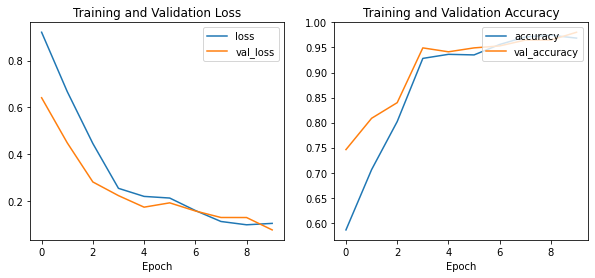

In [214]:
# Plot training and validation loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label = 'val_loss')
ax[0].title.set_text('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[1].title.set_text('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

### Testing Model

In [215]:
from keras.metrics import SparseCategoricalAccuracy

In [216]:
acc = SparseCategoricalAccuracy()

for batch in test.as_numpy_iterator():
    x, y = batch
    acc.update_state(y, model.predict(x))
print("Testing Accuracy: ", acc.result().numpy())

1/1 [==============================] - 0s 125ms/step
Testing Accuracy:  0.96190476


1/1 [==============================] - 0s 29ms/step


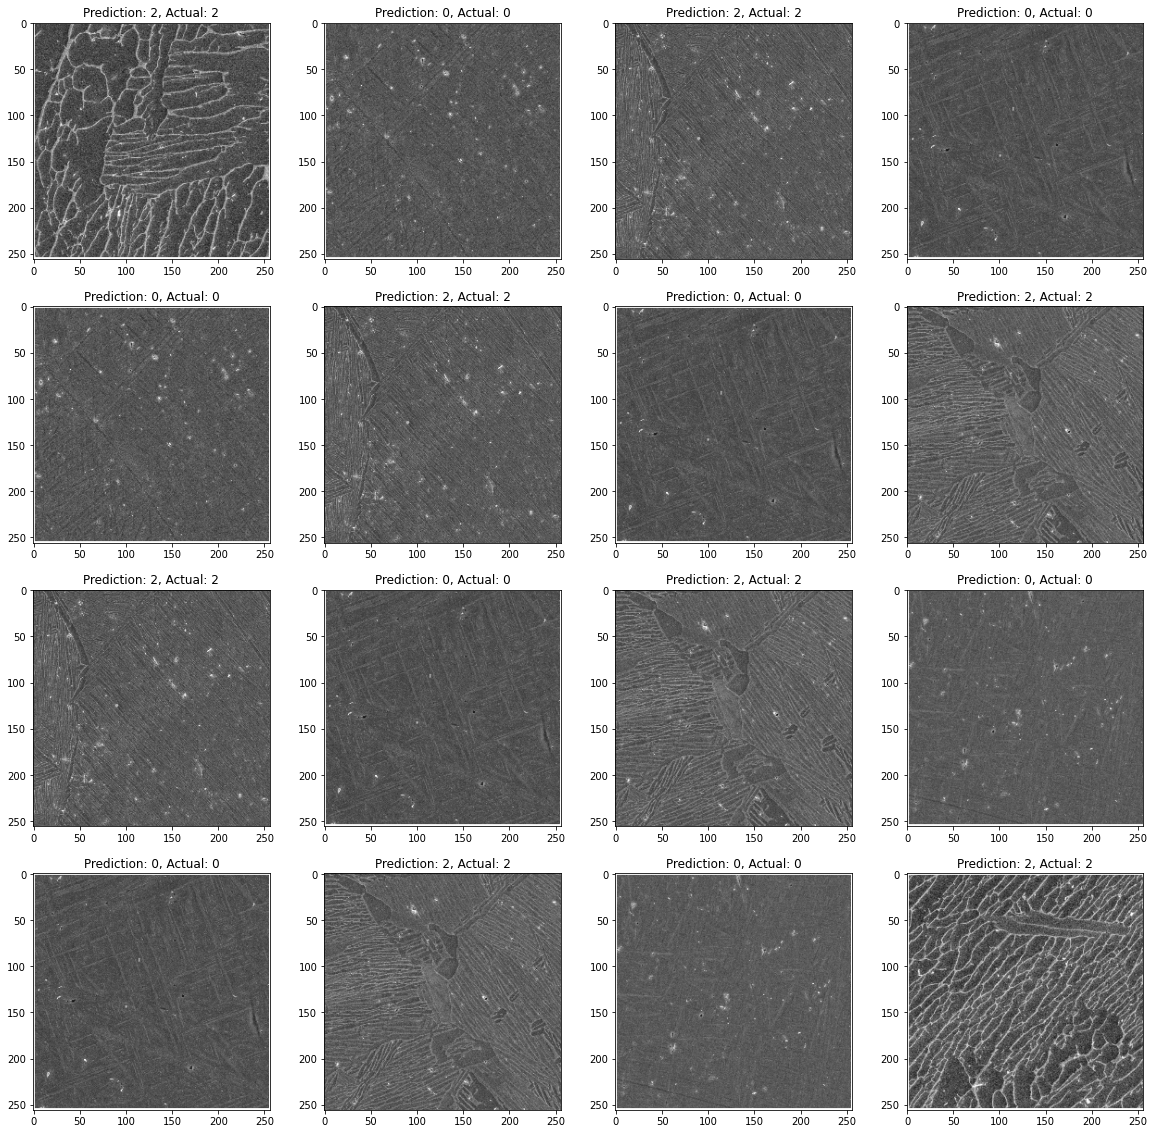

In [217]:
# Same but 16 images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(batch[0][i+j])
        ax[i,j].title.set_text(f'Prediction: {np.argmax(model.predict(batch[0][i+j][None]))}, Actual: {batch[1][i+j]}')

### Save Model

In [218]:
import os
from keras.models import load_model

In [219]:
path = os.path.join('models', 'titanium-classifier.h5')
model.save(path)